# Activations, BatchNorm and Gradients

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)   
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])    
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [9]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 24.0032
  10000/ 200000: 2.1610
  20000/ 200000: 2.1793
  30000/ 200000: 2.2183
  40000/ 200000: 2.3397
  50000/ 200000: 2.2718
  60000/ 200000: 2.2837
  70000/ 200000: 2.6655
  80000/ 200000: 2.6785
  90000/ 200000: 2.2867
 100000/ 200000: 2.4043
 110000/ 200000: 1.9055
 120000/ 200000: 2.1928
 130000/ 200000: 1.9425
 140000/ 200000: 1.8348
 150000/ 200000: 2.4772
 160000/ 200000: 2.2172
 170000/ 200000: 1.8460
 180000/ 200000: 1.9226
 190000/ 200000: 2.1241


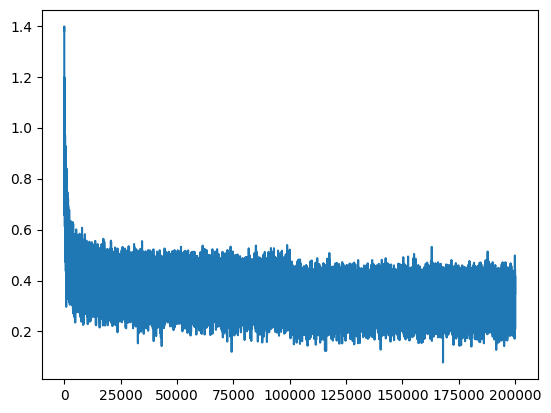

In [10]:
plt.plot(lossi)
plt.show()

In [26]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [13]:
split_loss("train")
split_loss("val")

train 2.1252517700195312
val 2.171226978302002


In [14]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

mora.
mayah.
seel.
nah.
yal.
ren.
rucendrae.
caileed.
elin.
shy.
jen.
eden.
estanaraelyn.
malkelin.
shuberlyni.
jest.
jair.
jenipanthono.
ubelleda.
kylynn.


1st problem: Very high loss at the beginning of training

Fixing Initial Loss

In [17]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
probs   

tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [21]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # since logits are calculated by W2 * h, so we also want W2 to be low. We should not set to 0, it can create problems. Can also try 0.01. (First tried 0.1)
b2 = torch.randn(vocab_size, generator=g) * 0 # since we want to generate all equal logits for the first time, so that loss can be less in the first time

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [19]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break # breaking after first iteration to see the iteration at first loss

      0/ 200000: 3.3221


Yes we getting low loss, as comparated to 27

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


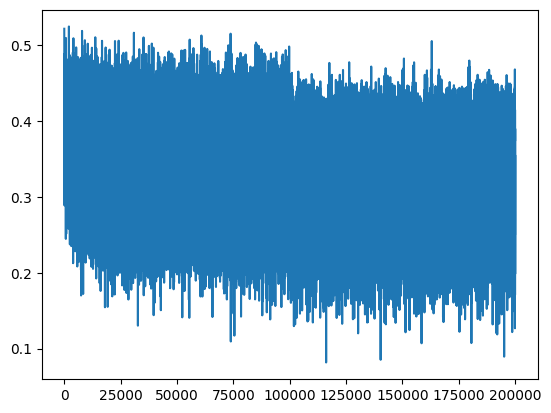

In [22]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
plt.plot(lossi)
plt.show()

So now loss no  move have hockey shape. This is good because now we are not squashing high loss values to low values.

In [23]:
split_loss("train")
split_loss("val")

train 2.069589138031006
val 2.1310746669769287


Quite bit imporved than earlier.

2nd problem: Saturated tanh

In [6]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3221


Loss is now good, but issue is with "h"

In [ ]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

Many values are 1.0 or -1.0. Tanh is a squashing function. It takes arbitrary number and squashes them b/w -1.0 and 1.0 and does it smoothly 

In [9]:
h.shape

torch.Size([32, 200])

In [10]:
h.view(-1).shape

torch.Size([6400])

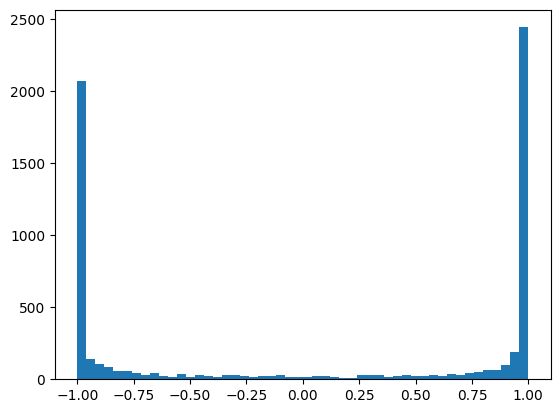

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

Most of the values are taking -1.0 or 1.0.

Why this is happening? Because hpreact is taking very broad distribution like -15 to 15. That's why tanh is squashing them to -1.0 or 1.0. 

See below plot

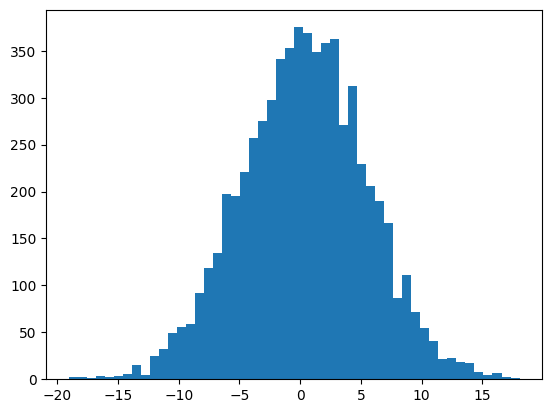

In [13]:
plt.hist(hpreact.view(-1).tolist(), 50);

This is an issue in backpro because it will eventually kill an gradient, because derivative of tanh is (1 - t**2) where t is tanh value, if t is 1.0 or -1.0, then derivative is 0.0. So no gradient will flow back. 

Intutively, we are calculating gradient with respect to loss, so tanh is having 1, which means straight line on graph, this means changing input will not going to change output as it will going to remain straight line only. 

And if t = 0, then gradient will just flow backward, tanh will not do anything. But more we are in flat tail of tanh, more the gradient will be squashed.

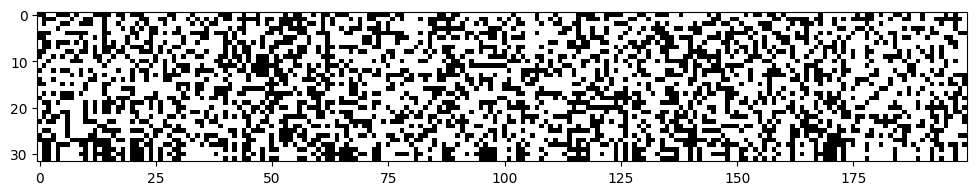

In [14]:
# checking how often `h` is in flat tail

plt.figure(figsize=(12, 6))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

We would be in more trouble if whole column will be white, what that will mean is basically dead neuron and it will never learn.

Fixing saturated tanh problem

In [17]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # since logits are calculated by W2 * h, so we also want W2 to be low. We should not set to 0, it can create problems. Can also try 0.01. (First tried 0.1)
b2 = torch.randn(vocab_size, generator=g) * 0 # since we want to generate all equal logits for the first time, so that loss can be less in the first time

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    # hpreact is too far from 0 and thus causing an issue. Thus we want it to closer to 0. This we will sqush W1 and b1.
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break # breaking after first iteration to see the iteration at first loss

      0/ 200000: 3.3069


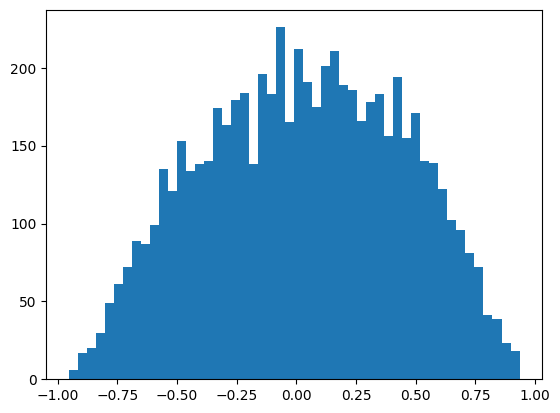

In [19]:
plt.hist(h.view(-1).tolist(), 50);

Now, we have much better histogram. That's because hpreact is not taking very broad distribution. It is taking values b/w -1.5 to 1.5.

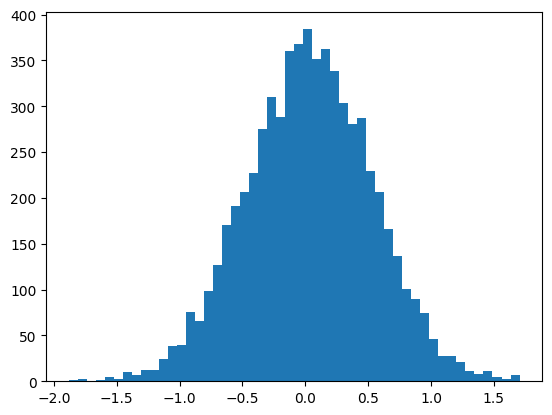

In [20]:
plt.hist(hpreact.view(-1).tolist(), 50);

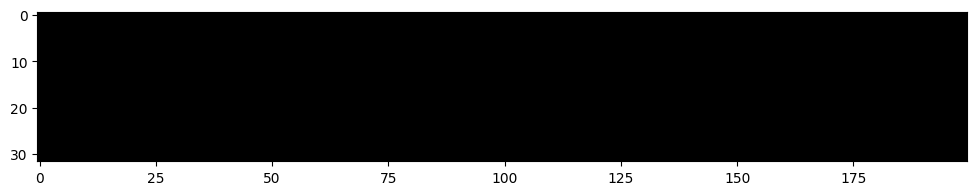

In [ ]:
# checking how often `h` is in flat tail

plt.figure(figsize=(12, 6))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

There is no more white. Waoohh. That's because there are no more neurons that got saturated in either direction.

Trying 0.2 value

11897
      0/ 200000: 3.3135


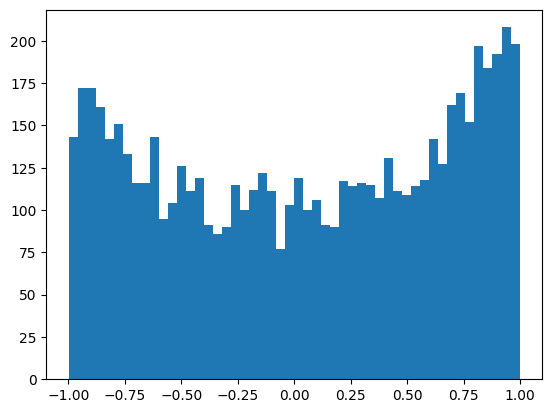

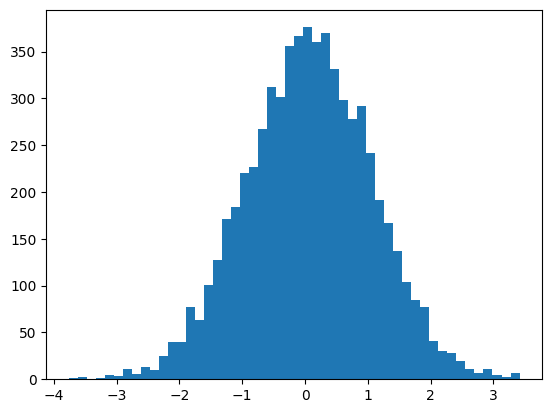

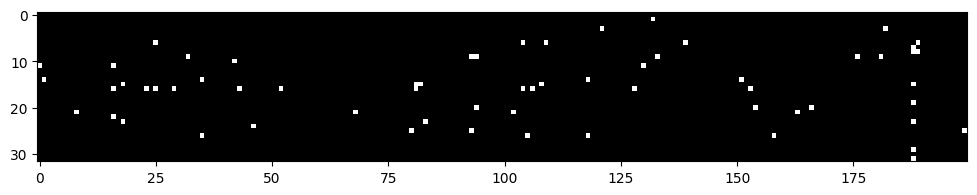

In [23]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # since logits are calculated by W2 * h, so we also want W2 to be low. We should not set to 0, it can create problems. Can also try 0.01. (First tried 0.1)
b2 = torch.randn(vocab_size, generator=g) * 0 # since we want to generate all equal logits for the first time, so that loss can be less in the first time

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    # hpreact is too far from 0 and thus causing an issue. Thus we want it to closer to 0. This we will sqush W1 and b1.
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break # breaking after first iteration to see the iteration at first loss


plt.hist(h.view(-1).tolist(), 50)
plt.show()
plt.hist(hpreact.view(-1).tolist(), 50)
plt.show()

# checking how often `h` is in flat tail
plt.figure(figsize=(12, 6))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

This is pretty good distribution.

Let's run full optimization

In [24]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # since logits are calculated by W2 * h, so we also want W2 to be low. We should not set to 0, it can create problems. Can also try 0.01. (First tried 0.1)
b2 = torch.randn(vocab_size, generator=g) * 0 # since we want to generate all equal logits for the first time, so that loss can be less in the first time

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    # hpreact is too far from 0 and thus causing an issue. Thus we want it to closer to 0. This we will sqush W1 and b1.
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


In [27]:
split_loss("train")
split_loss("val")

train 2.0355966091156006
val 2.1026782989501953


Much better

Kaiming Init

tensor(-0.0077) tensor(0.9887)
tensor(0.0146) tensor(3.1064)


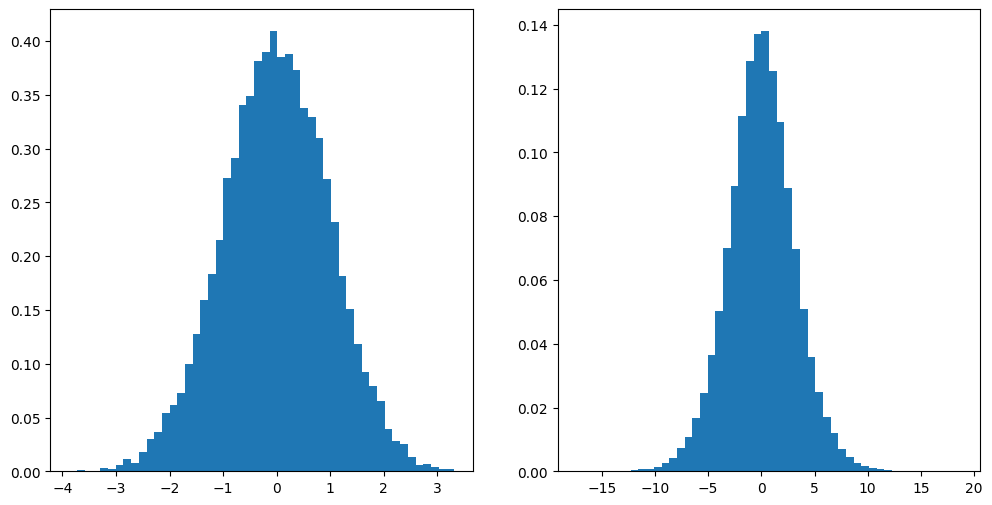

In [28]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

We can see that mean is staying same, but std is increasing. We want to keep unit gaussian throughout the network. So how can we change the std by multiplying w by what?

SO we do it by dividing by sqrt of fan_in, which is number of input connections.

tensor(0.0051) tensor(1.0116)
tensor(-0.0033) tensor(1.0311)


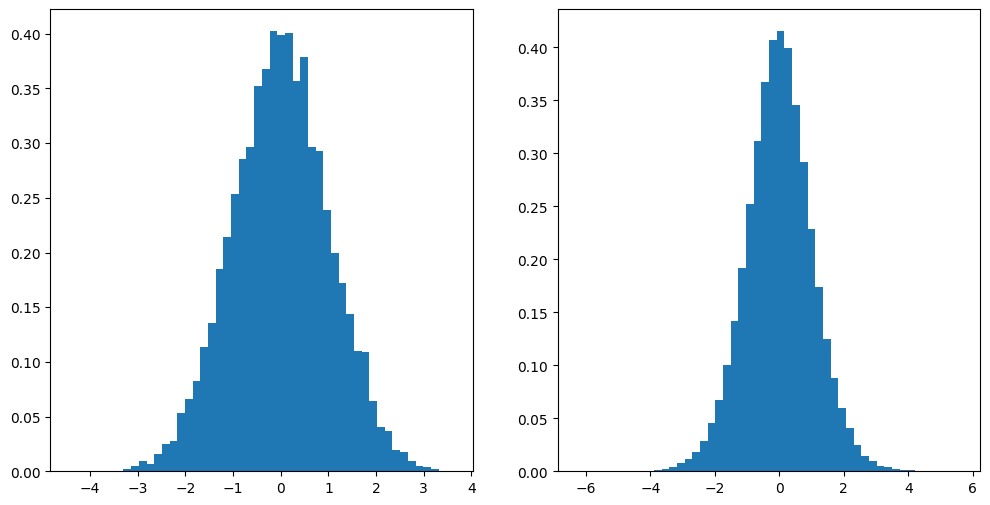

In [32]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

We can see that mean and std is preserved. 

Kaiminginit = sqrt(gain / fan_in), for tanh, gain is 5/3

In [33]:
(5/3) / ((n_emb*block_size) ** 0.5)

0.3042903097250923

In [34]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3) / ((n_emb*block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # since logits are calculated by W2 * h, so we also want W2 to be low. We should not set to 0, it can create problems. Can also try 0.01. (First tried 0.1)
b2 = torch.randn(vocab_size, generator=g) * 0 # since we want to generate all equal logits for the first time, so that loss can be less in the first time

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    # hpreact is too far from 0 and thus causing an issue. Thus we want it to closer to 0. This we will sqush W1 and b1.
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
split_loss("train")
split_loss("val")

11897
      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614
train 2.0376644134521484
val 2.106989622116089


We end up in same spot as 0.2

These days we do not require precise initilization because of modern inovations. One such in batchnorm.

Batch Normalization

We want hpreact to have mean 0 and std 1. SO batchnorm says that, why don't we just take hpreact and normalize them to be gaussian.

In [35]:
hpreact.shape

torch.Size([32, 200])

In [38]:
hpreact.mean(0, keepdim=True).shape # doing mean of all the elemnts in the batch

torch.Size([1, 200])

In [39]:
hpreact.std(0, keepdim=True).shape 

torch.Size([1, 200])

In [40]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3) / ((n_emb*block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization
    # we need to scale and shift because we want nn to move the distribution around.  Else we won't get good loss.
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

12297
      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In production, we want to predict from one example, but our model expects it in batch because of batchnorm. So we need to do something about it.

To solve this, we need to calculate batchnorm statistics after training. 

In [43]:
# calibrate batchnorm after training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure mean and std over entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

No one wants to do these steps after training. So we can calculate during training.

In [44]:
# now we can also forward a single example

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("val")

train 2.0668270587921143
val 2.1049270629882812


Calculating batchnorm statistics during training

In [45]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) 
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3) / ((n_emb*block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    bnmeani = hpreact.mean(0, keepdim=True) # for ith iteration
    bnstdi = hpreact.std(0, keepdim=True) # for ith iteration
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias # batch normalization
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

12297
      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


We expect bnmean and bstd to be roughly equal to bnmean_running and bstd_running.

In [46]:
# now we can also forward a single example

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("val")

train 2.06659197807312
val 2.1050572395324707


There is no need for bias in the layer above batch norm, because we are anyway subtracting the mean, so bias is automatically subtracted. This bias is taken care by the bias of the batchnorm layer. 

If we see, then grad of bias of the layer above batchnorm will be 0.

In [48]:
b1.grad[:10]

tensor([ 4.6566e-10, -4.6566e-10,  8.7311e-10, -2.3283e-10, -2.3283e-10,
         9.3132e-10, -1.3970e-09, -9.3132e-10,  0.0000e+00, -6.5193e-09])

Avoid BatchNorm as much as possible. Try to use LayerNorm or GroupNorm as they are more widely used in recent times.

PyTorch-ifying the code

In [60]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:    
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __init__(self):
        pass
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g) 

layers = [
    Linear(n_emb*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [51]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.2962


visualize histograms of activations specifically at tanh layers

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12


Text(0.5, 1.0, 'activation distrubutions')

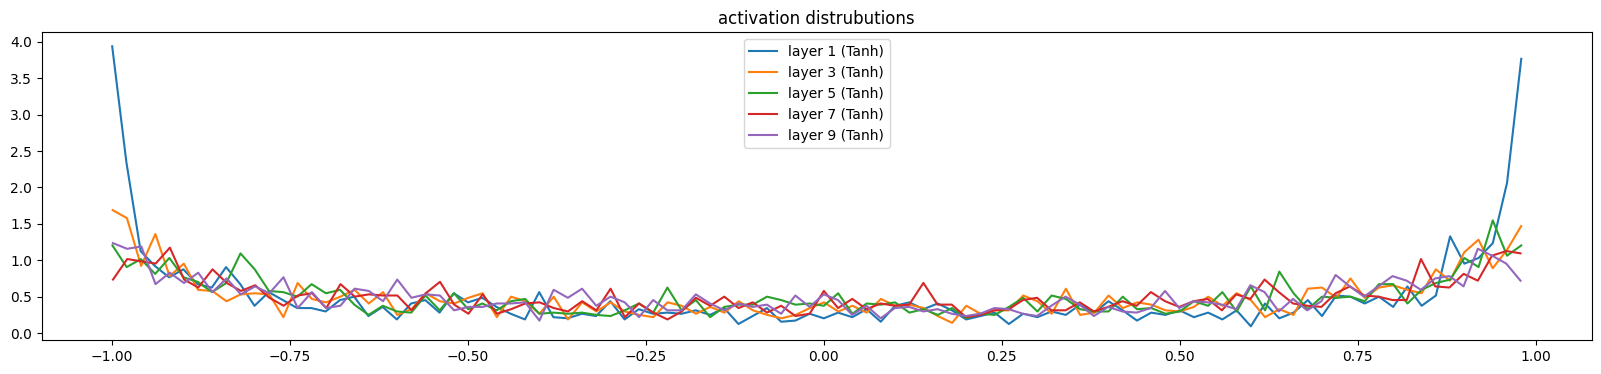

In [52]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distrubutions")

We can change the gain (5/3) above and see how graph reacts to it. Setting it to a high value will lead more layers to more saturation and setting it to 1, wiill squash the values to 0.

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distrubution')

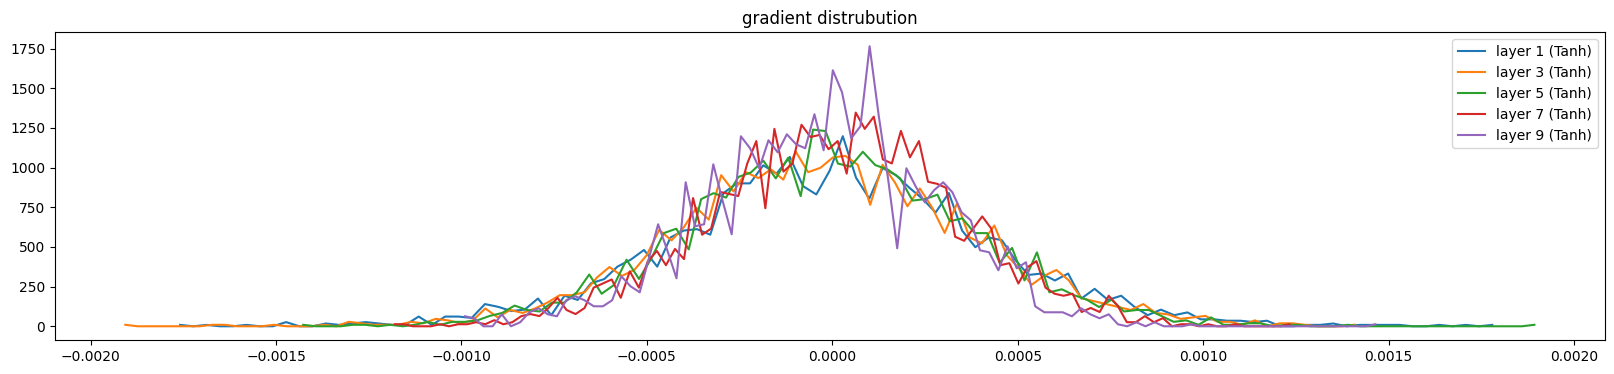

In [56]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distrubution")

Change gain and see the graph. If gain set to small value like 0.5, gradients will behave weird

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


Text(0.5, 1.0, 'weight gradient distrubution')

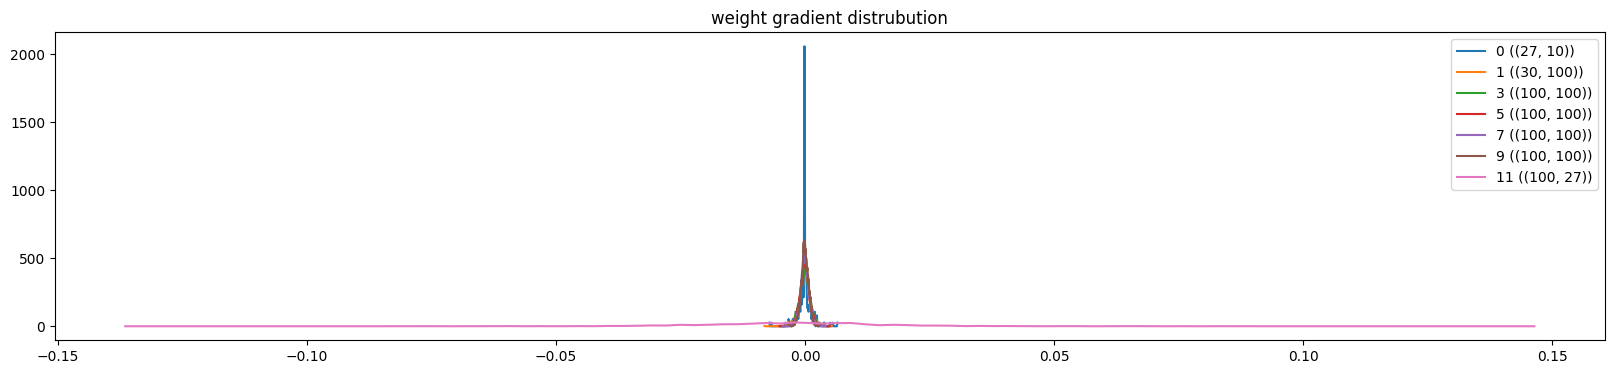

In [59]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} ({tuple(p.shape)})")
plt.legend(legends)
plt.title("weight gradient distrubution")

The last layer is troublemaker, as we can see its weights are 10x greater than all the other layers weights. This will be solved after training for few iterations and will also be solved by using modern optimizers such as adam.

What matters is update:data ratio not grad:data ratio, because it is the amount that we will change the data.

In [61]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53


Text(0.5, 1.0, 'activation distrubutions')

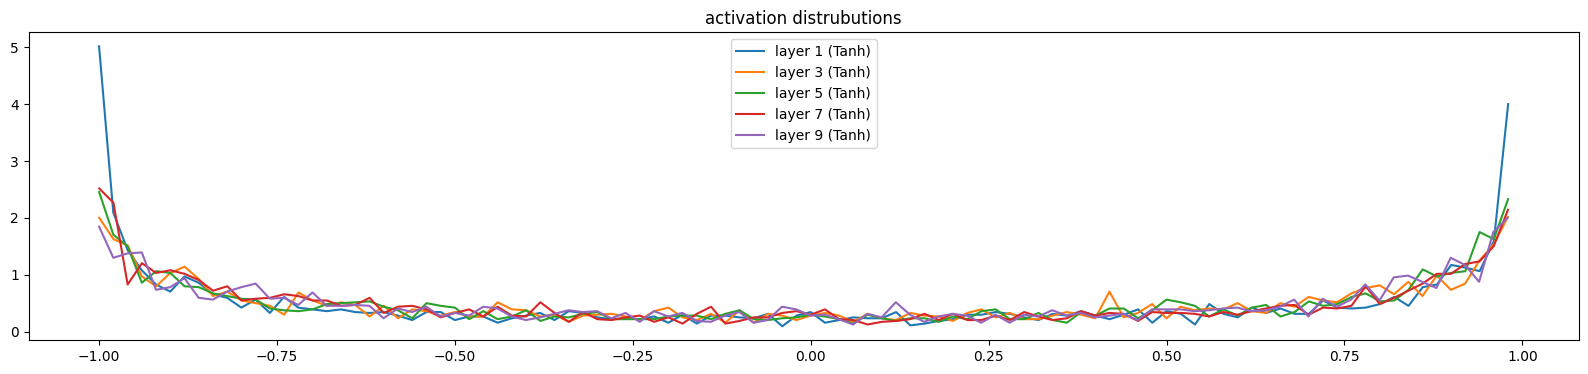

In [62]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distrubutions")

layer 1 (      Tanh): mean +0.000024, std 3.353993e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distrubution')

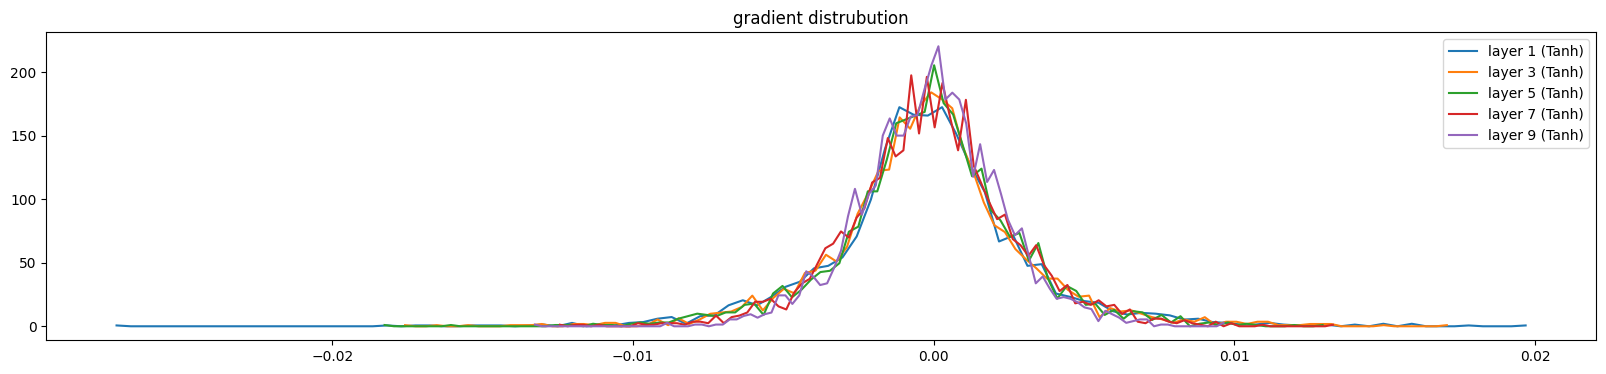

In [63]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distrubution")

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821214e-03 | grad:data ratio 4.653364e-02
weight (100, 100) | mean -0.000107 | std 6.655623e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086042e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


Text(0.5, 1.0, 'weight gradient distrubution')

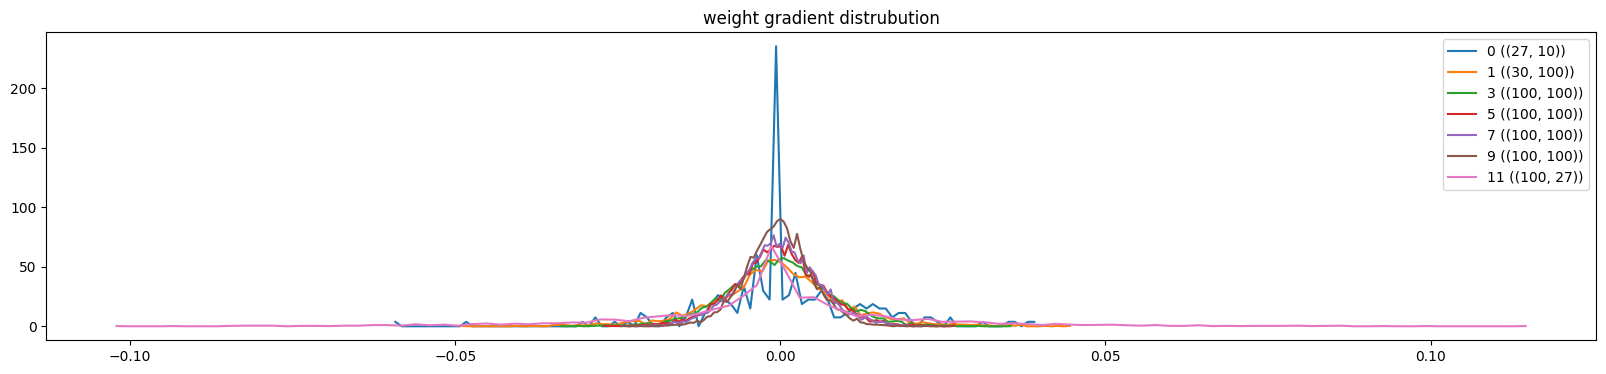

In [64]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} ({tuple(p.shape)})")
plt.legend(legends)
plt.title("weight gradient distrubution")

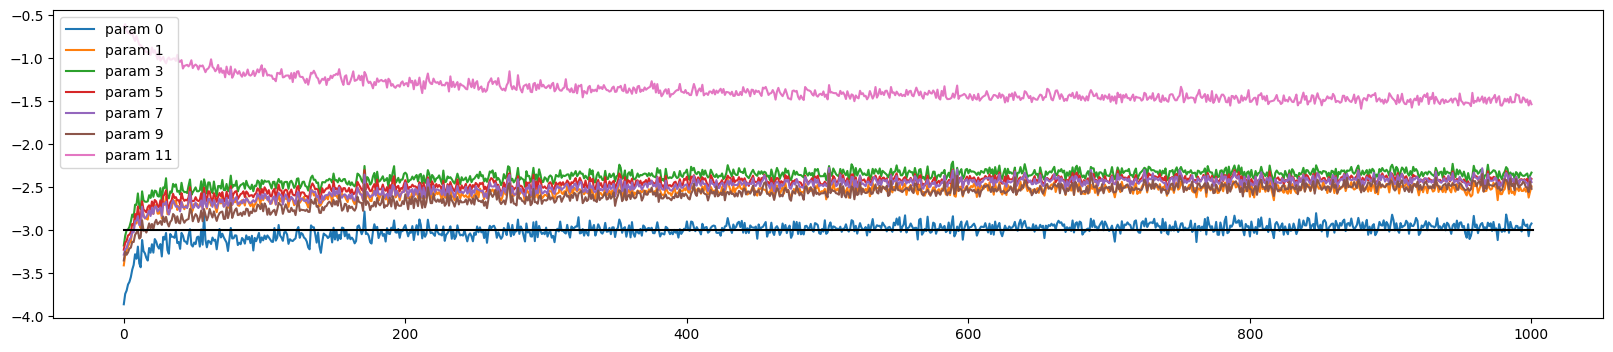

In [66]:
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends);

If LR will be low, then this plot will reveal it, because most of the lines of the graph will be below that black line, this means network is not learning fast enough

Thus without batchnorm, we have to carefully set the gains.

In [67]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:    
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __init__(self):
        pass
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g) 

layers = [
    Linear(n_emb*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),  BatchNorm1d(vocab_size)
] # it is fine to put BatchNorm at the end also

with torch.no_grad():
    # make last layer less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [68]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break

      0/ 200000: 3.2906


layer 2 (      Tanh): mean +0.54, std 0.50, saturated: 14.06
layer 5 (      Tanh): mean +0.55, std 0.50, saturated: 13.66
layer 8 (      Tanh): mean +0.55, std 0.50, saturated: 13.53
layer 11 (      Tanh): mean +0.55, std 0.51, saturated: 13.78
layer 14 (      Tanh): mean +0.55, std 0.51, saturated: 13.09


Text(0.5, 1.0, 'activation distrubutions')

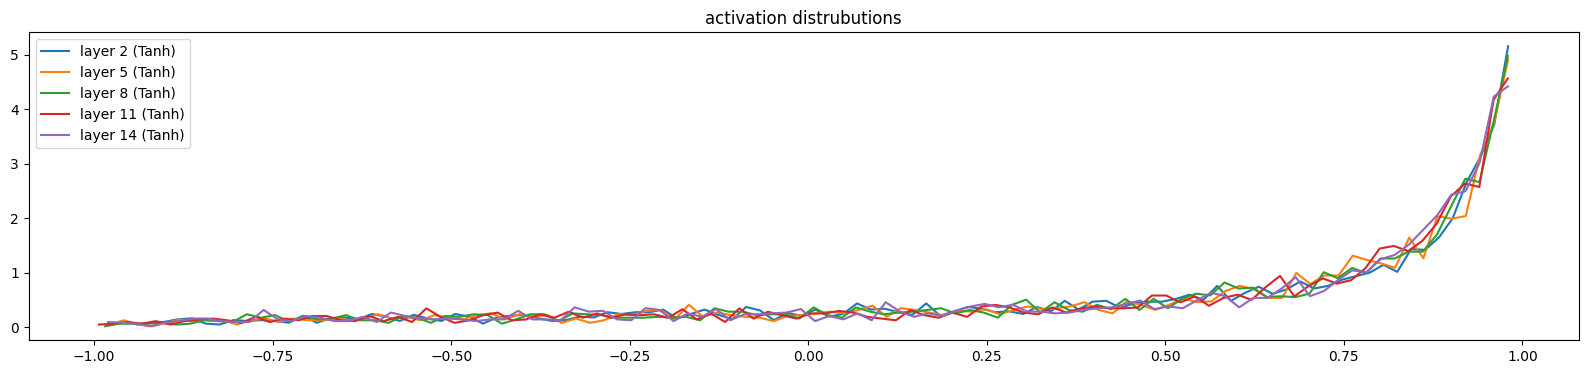

In [70]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distrubutions")

layer 2 (      Tanh): mean -0.000000, std 4.912395e-03
layer 5 (      Tanh): mean +0.000000, std 4.218515e-03
layer 8 (      Tanh): mean -0.000000, std 3.650499e-03
layer 11 (      Tanh): mean -0.000000, std 3.296271e-03
layer 14 (      Tanh): mean +0.000000, std 3.124819e-03


Text(0.5, 1.0, 'gradient distrubution')

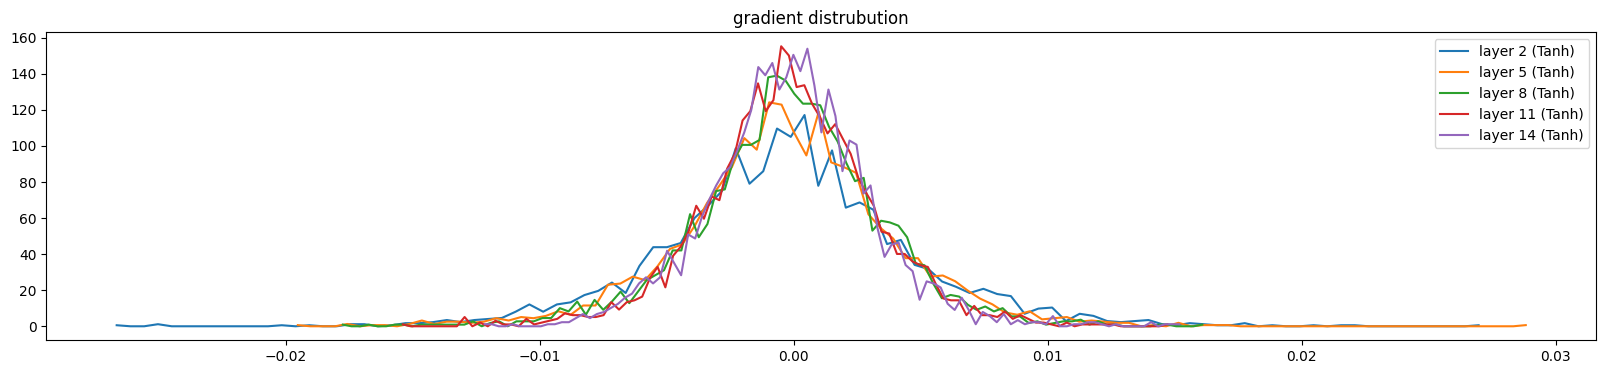

In [71]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distrubution")

weight   (27, 10) | mean -0.000000 | std 1.034036e-02 | grad:data ratio 1.032930e-02
weight  (30, 100) | mean -0.000016 | std 9.517262e-03 | grad:data ratio 3.042914e-02
weight (100, 100) | mean +0.000167 | std 7.916003e-03 | grad:data ratio 4.731938e-02
weight (100, 100) | mean -0.000018 | std 6.388383e-03 | grad:data ratio 3.786429e-02
weight (100, 100) | mean +0.000017 | std 5.571677e-03 | grad:data ratio 3.319684e-02
weight (100, 100) | mean +0.000025 | std 4.885157e-03 | grad:data ratio 2.910568e-02
weight  (100, 27) | mean +0.000025 | std 1.013769e-02 | grad:data ratio 6.087857e-02


Text(0.5, 1.0, 'weight gradient distrubution')

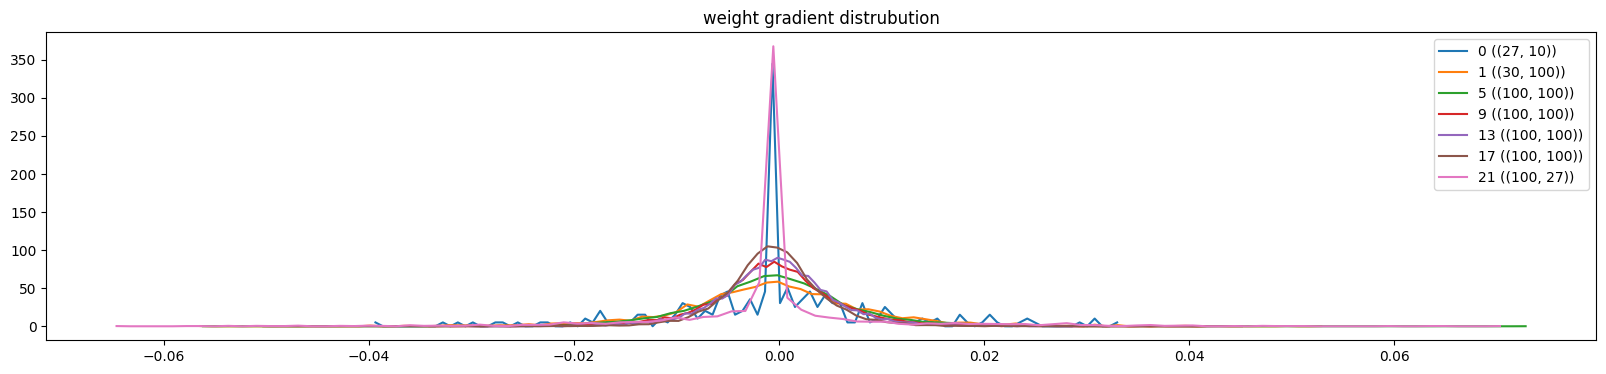

In [72]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} ({tuple(p.shape)})")
plt.legend(legends)
plt.title("weight gradient distrubution")

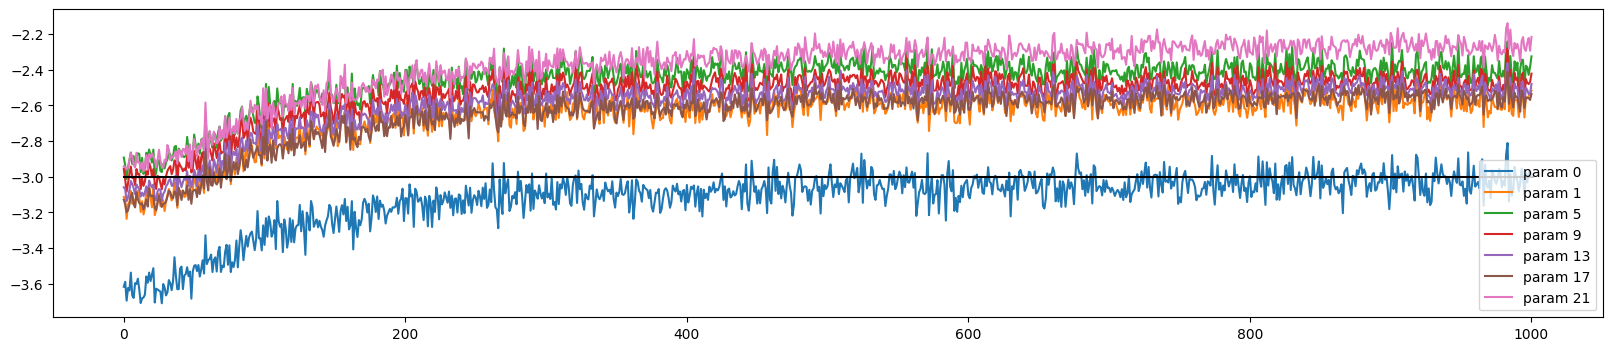

In [73]:
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends);